# 57 Creating Spaghetti plots in GemPy

This notebook illustrates how to create spaghetti plots in GemPy illustrating the variety of model outcomes when performing probabilistic modeling in GemPy. This notebook was adapted from the work done here: https://github.com/elimh/stochastic-simulations-in-gempy.

<img src="../images/tutorial57_cover.png">

## Set File Paths and download Tutorial Data

If you downloaded the latest `GemGIS` version from the Github repository, append the path so that the package can be imported successfully. Otherwise, it is recommended to install `GemGIS` via `pip install gemgis` and import `GemGIS` using `import gemgis as gg`. In addition, the file path to the folder where the data is being stored is set. The tutorial data is downloaded using Pooch (https://www.fatiando.org/pooch/latest/index.html) and stored in the specified folder. Use `pip install pooch` if Pooch is not installed on your system yet.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import geopandas as gpd
import pandas as pd
import gempy as gp
import gemgis as gg

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
file_path ='data/57_creating_spaghettii_plots_in_gempy/'
gg.download_gemgis_data.download_tutorial_data(filename="57_creating_spaghettii_plots_in_gempy.zip", dirpath=file_path)

## Loading the Interface and Orientations Data

The interface and orientation data is provided for a simple syncline model as Shapefile. 

In [3]:
interfaces = gpd.read_file('data/57_creating_spaghettii_plots_in_gempy/SynclineInterfaces.shp')
orientations = gpd.read_file('data/57_creating_spaghettii_plots_in_gempy/SynclineInterfaces.shp')

## Deleting columns and dropping geometries

In [4]:
del interfaces['polarity']
del interfaces['dip']
del interfaces['azimuth']
interfaces['Z'] = -100
orientations['Z'] = -100

interfaces = pd.DataFrame(interfaces.drop(columns='geometry'))

orientations = pd.DataFrame(orientations.drop(columns='geometry'))

## Inspecting DataFrames

In [5]:
interfaces.head()

,X,Y,Z,formation
0,200,100,-100,Layer3
1,400,100,-100,Layer3
2,600,100,-100,Layer3
3,800,100,-100,Layer3
4,200,200,-100,Layer2


In [6]:
orientations.head()

,X,Y,Z,formation,polarity,azimuth,dip
0,200,100,-100,Layer3,1,0,45
1,400,100,-100,Layer3,1,0,45
2,600,100,-100,Layer3,1,0,45
3,800,100,-100,Layer3,1,0,45
4,200,200,-100,Layer2,1,0,45


## Creating GemPy Model

### Initiate Model

A relatively low resolution is chosen to speed up the modeling process. 

In [7]:
geo_model = gp.create_model('Model1')

In [8]:
gp.init_data(geo_model, [0, 1000, 0, 1000, -500,0], [30,30,30],
             surface_points_df = interfaces,
             orientations_df = orientations,
             default_values=True)
geo_model.surfaces

Active grids: ['regular']


,surface,series,order_surfaces,color,id
0,Layer3,Default series,1,#015482,1
1,Layer2,Default series,2,#9f0052,2
2,Layer1,Default series,3,#ffbe00,3


### Map Stack to Surfaces

In [9]:
gp.map_stack_to_surfaces(geo_model,
                         {"Strat_Series": ('Layer1', 'Layer2', 'Layer3')},
                         remove_unused_series=True)
geo_model.add_surfaces('basement')

,surface,series,order_surfaces,color,id
0,Layer3,Strat_Series,1,#015482,1
1,Layer2,Strat_Series,2,#9f0052,2
2,Layer1,Strat_Series,3,#ffbe00,3
3,basement,Strat_Series,4,#728f02,4


### Plot Input Data

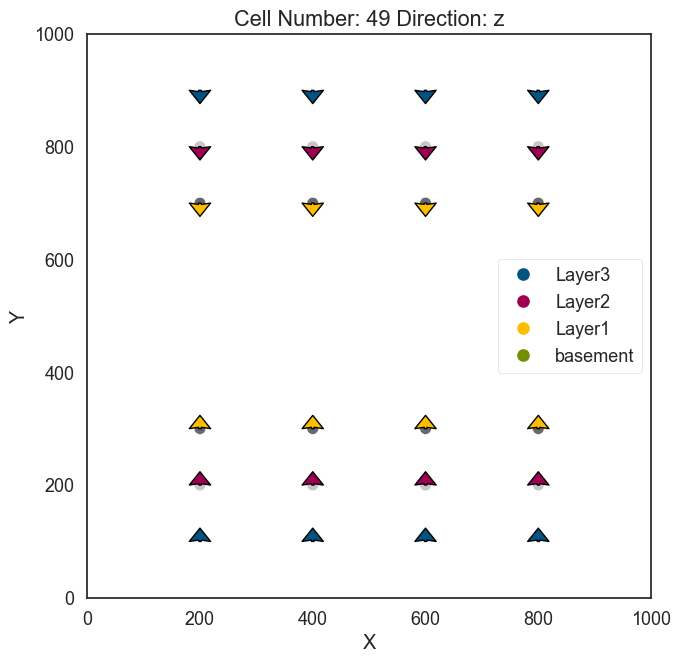

In [10]:
gp.plot_2d(geo_model, direction='z', cell_number = 49)

### Creat custom section for Spaghetti Plot

A custom section needs to be created to later obtain the Spaghetti Plot

Active grids: ['regular' 'sections']


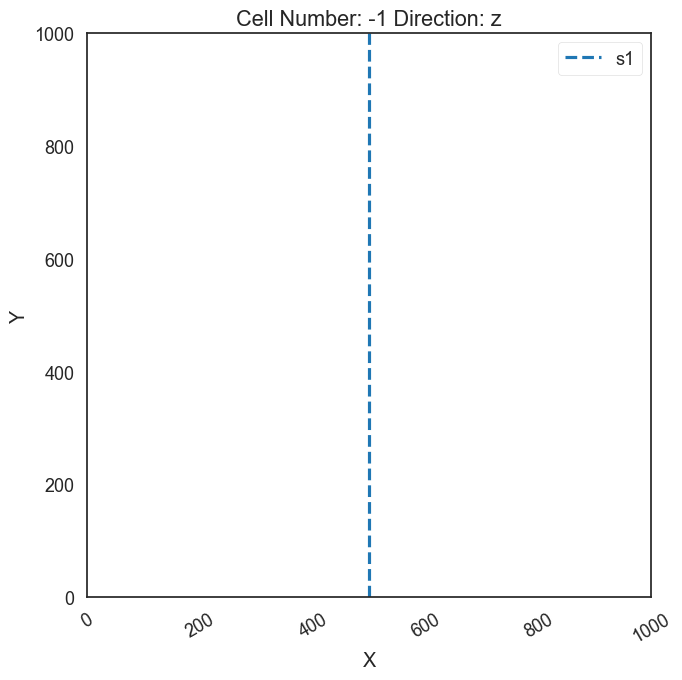

In [11]:
geo_model.set_section_grid({'s1':([500,0],[500,1000],[80,80])})
gp.plot.plot_section_traces(geo_model)

### Set Interpolator

In [12]:
gp.set_interpolator(geo_model,
                    compile_theano=True,
                    theano_optimizer='fast_compile',
                    verbose=[],
                    update_kriging = False
                    )

Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                   values
range            1500.00
$C_o$           53571.43
drift equations      [3]


### Compute Model

In [13]:
sol = gp.compute_model(geo_model)

### Plot Model

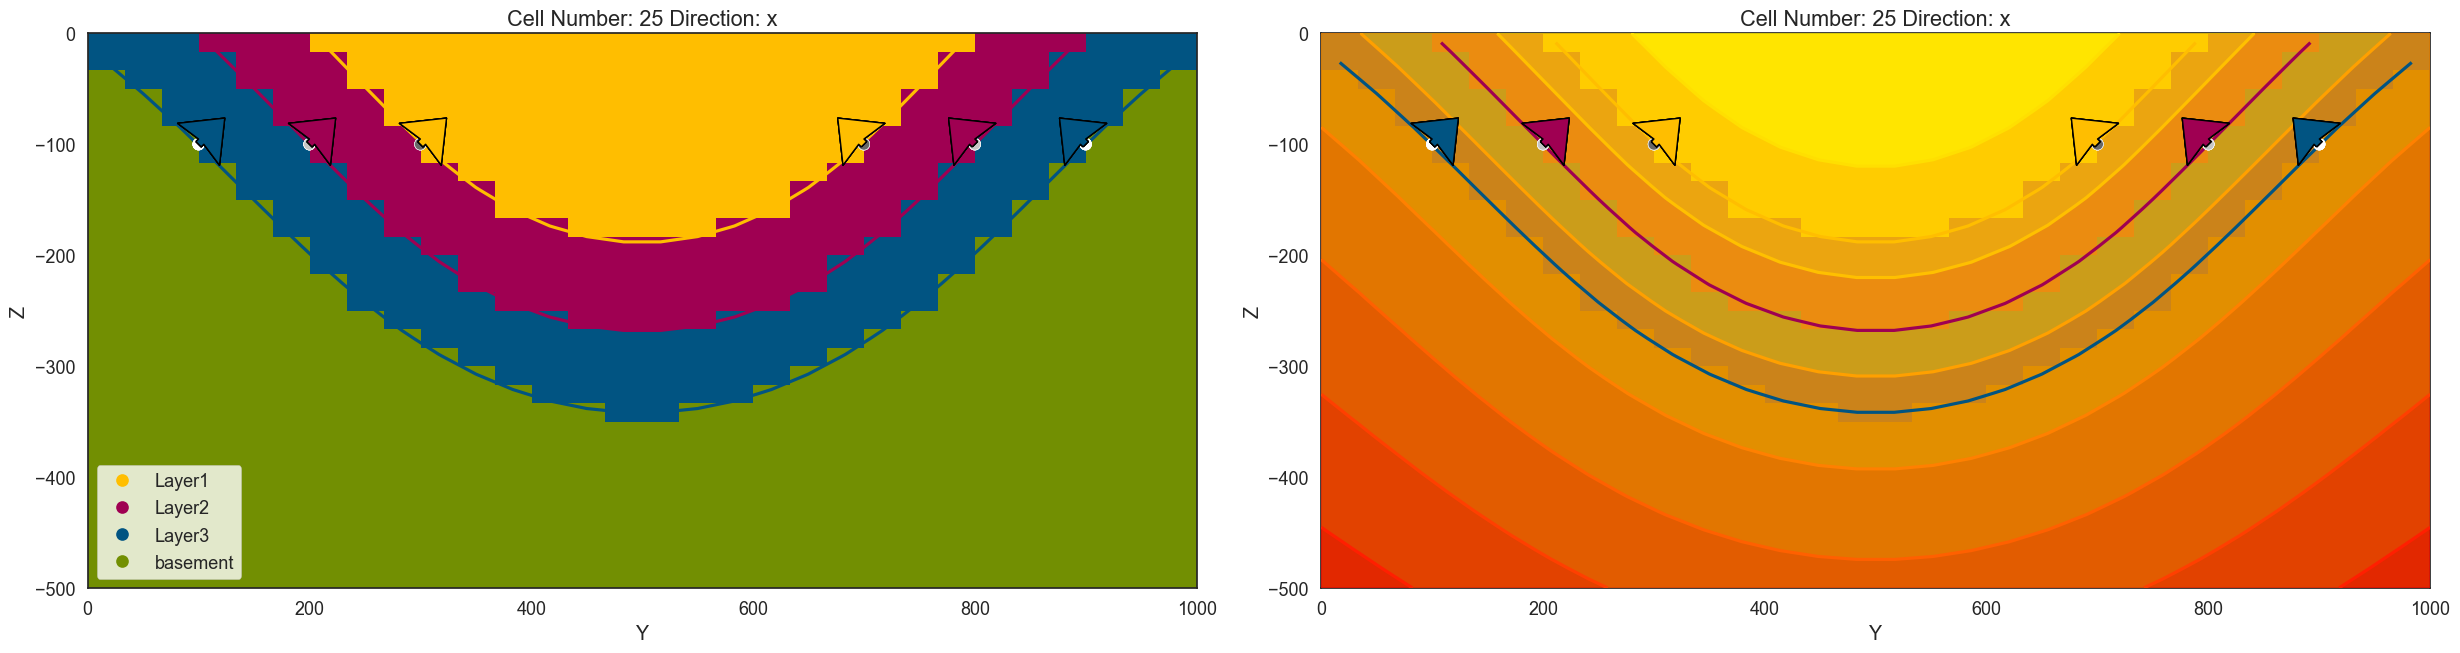

In [14]:
gp.plot_2d(geo_model, direction=['x', 'x'], cell_number=[25, 25,], show_data=True, show_scalar = [False, True])

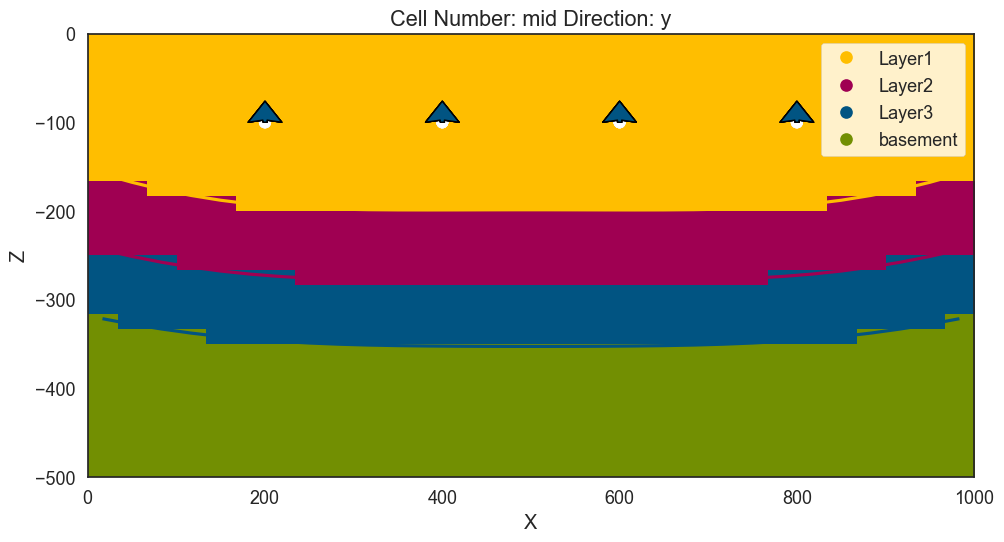

In [15]:
gp.plot_2d(geo_model, section=['s1'])

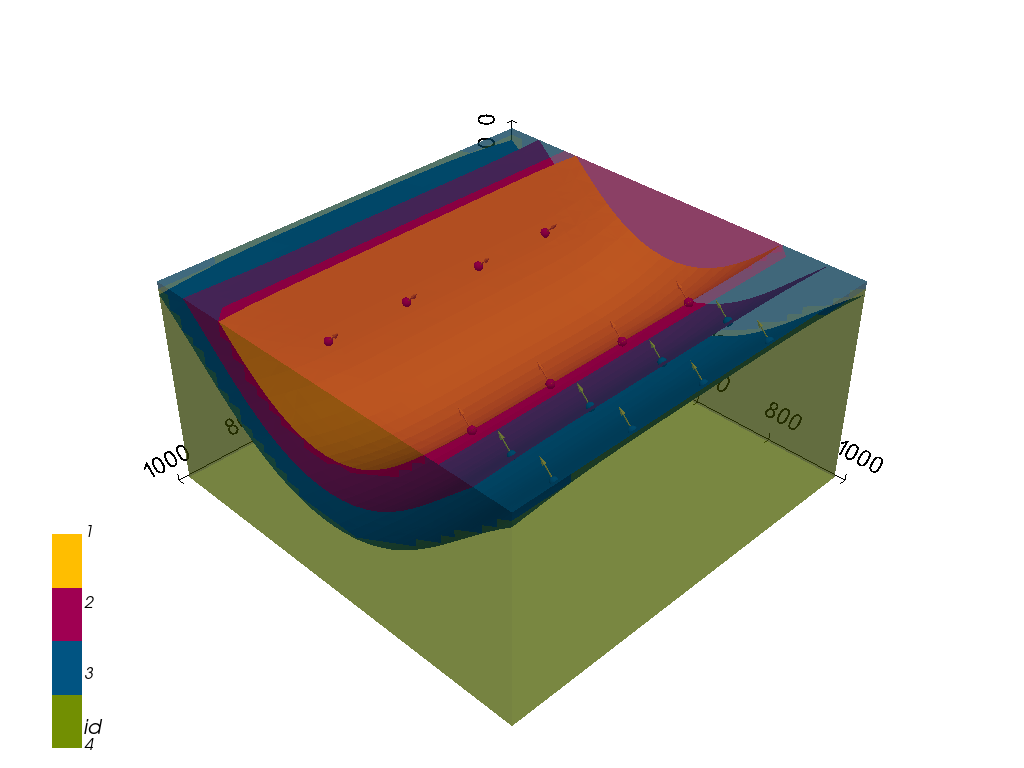

In [16]:
gpv = gp.plot_3d(geo_model, 
                 image=False, 
                 show_topography=True,
                 plotter_type='basic', 
                 notebook=True)

## Probabilistic Modeling

During the probabilistic modeling, multiple model realizations will be created by varying the input parameter and recomputing the models with the new input data. The Monte Carlo approach is the base for the Spaghetti plot. 

In [17]:
from gempy.bayesian.fields import compute_prob, calculate_ie_masked
from gempy.core.grid_modules import section_utils
from tqdm.notebook import tqdm
import numpy as np
import copy 

### Getting polygondict for the spaghetti plot 

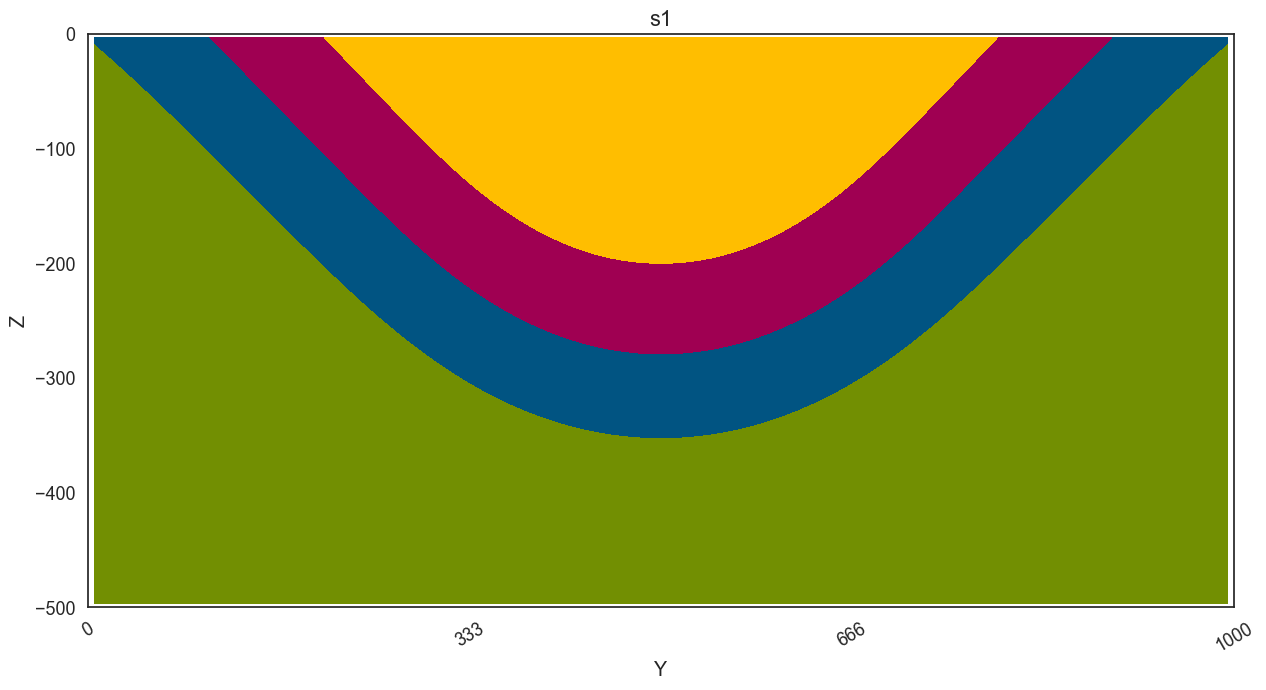

In [18]:
polygondict_s1, cdict, extent = section_utils.get_polygon_dictionary(geo_model, 's1');

### Copying the original model data

A deep copy is created for all interface points and locations as well as their indices. 

In [19]:
df_int_X = copy.copy(geo_model.surface_points.df['X'])
df_int_Y = copy.copy(geo_model.surface_points.df['Y'])
df_int_Z = copy.copy(geo_model.surface_points.df['Z'])

df_or_X = copy.copy(geo_model.orientations.df['X'])
df_or_Y = copy.copy(geo_model.orientations.df['Y'])
df_or_Z = copy.copy(geo_model.orientations.df['Z'])
df_or_dip     = copy.copy(geo_model.orientations.df['dip'])
df_or_azimuth = copy.copy(geo_model.orientations.df['azimuth'])

surfindexes = list(geo_model.surface_points.df.index)
orindexes = list(geo_model.orientations.df.index)

### Monte Carlo Simulation

In [20]:
# Preventing matplotlib from plotting
%matplotlib agg

# Defining number of iterations
n_iterations = 50

# Getting indices
indices = list(geo_model.surface_points.df.index.sort_values()[:24])
indices_or = list(geo_model.orientations.df.index)

# Defining empty lith_block array
lith_blocks = np.array([])

# Defining empty list to store meshes
meshes = []

for iterations in tqdm(range(n_iterations)):

    # Setting seed for reproducability
    np.random.seed(iterations)

    # Resetting Dataframes
    geo_model.modify_surface_points(surfindexes, X=df_int_X, Y=df_int_Y, Z=df_int_Z)
    geo_model.modify_orientations(orindexes, X=df_or_X, Y=df_or_Y, Z=df_or_Z,dip = df_or_dip, azimuth = df_or_azimuth)
    geo_model.update_to_interpolator()

    # Modifying Points
    dip_sample = np.random.uniform(25,65, size=1)
    for i in range(len(indices_or)):
        geo_model.modify_orientations(indices_or[i], dip = dip_sample)

   # Setting Interpolator and compute model
    geo_model.update_to_interpolator()
    sol = gp.compute_model(geo_model, compute_mesh=True)
    
    
    #Spaghetti Plots
    polygondict, cdict, extent = section_utils.get_polygon_dictionary(geo_model, 's1')
    for form in polygondict.keys():
        polygondict_s1.get(form).append(polygondict.get(form))
        
    # Saving lith_block after each model run
    lith_blocks = np.append(lith_blocks, geo_model.solutions.lith_block)
#     np.save('lith_blocks_syncline_dip_all_new.npy', lith_blocks)
    
    # Exporting meshes using GemGIS
    mesh = gg.visualization.create_depth_maps_from_gempy(geo_model, surfaces=['Layer2'])
    meshes.append(mesh)

  0%|          | 0/50 [00:00<?, ?it/s]

### Reshaping lith_blocks array

In [21]:
# lith_blocks_syncline_dip_all = np.load('lith_blocks_syncline_dip_all.npy').reshape(n_iterations, -1)
prob_block_syncline_dip_all = compute_prob(lith_blocks.reshape(n_iterations, -1))
print(prob_block_syncline_dip_all.shape)
prob_block_syncline_dip_all

(4, 27000)


array([[0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.12],
       [0.  , 0.  , 0.  , ..., 0.5 , 0.64, 0.64],
       [1.  , 1.  , 1.  , ..., 0.5 , 0.36, 0.24]])

### Plotting Probabilities

The probabilities of each layer being present in a cell are plotted.

In [22]:
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt

In [23]:
def plot_probs(array):
    fig = plt.figure(figsize=(15, 5))

    grid = ImageGrid(fig, 111,          
                     nrows_ncols=(1,3),
                     axes_pad=0.5,
                     share_all=True,
                     cbar_location="right",
                     cbar_mode="each",
                     cbar_size="5%",
                     cbar_pad=0.15,
                     )
    cmaps = ['Greens', 'Blues', 'Reds']
    for counter, ax in enumerate(grid):
        im = ax.imshow(np.fliplr(array[counter].reshape(30,30,30)[
                       25].T), cmap=cmaps[counter], origin='lower', vmin=0, vmax=1)
        ax.set_xlabel('Cell Number',fontsize=18 )
        ax.set_ylabel('Cell Number',fontsize=18)
        ax.hlines(y=23.5,xmin=0,xmax=200, color='k')
        ax.set_xlim(0,30)
        ax.text(x=2, y=2, s='Layer ' + str(counter+1))
        
    
        cbar = ax.cax.colorbar(im)
        ax.tick_params(axis='both', which='major', labelsize=16)
        ax.tick_params(axis='both', which='minor', labelsize=16)
        cbar.ax.tick_params(axis='both', which='major', labelsize=14)
        cbar.ax.tick_params(axis='both', which='minor', labelsize=14)
        ax.cax.toggle_label(True)
    cbar.ax.set_ylabel('Probabilities', fontsize=16)
    

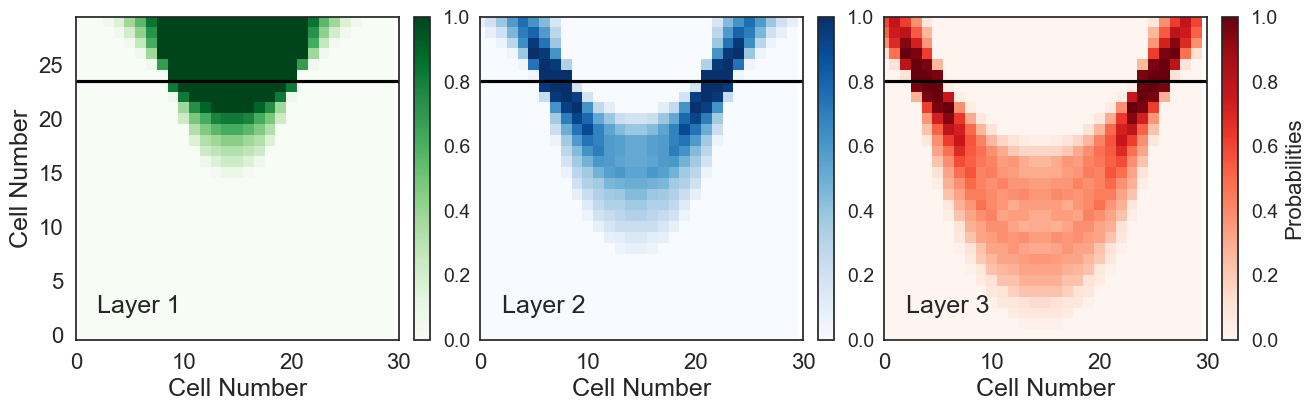

In [24]:
%matplotlib inline
plot_probs(prob_block_syncline_dip_all)

## Plotting Entropy and Spaghetti Plot

In [25]:
import matplotlib.patches as patches
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.path import Path

In [26]:
%matplotlib agg
fig, ax = plt.subplots()
def plot_pathdict(pathdict, cdict, extent, ax=None, surfaces=None, color=None):
    
    for formation in surfaces:
        print(formation)
        for path in pathdict.get(formation):
            if path !=[]:
                if type(path) == Path:
                    patch = patches.PathPatch(path, fill=False, lw=0.25, edgecolor=color)
                    ax.add_patch(patch)
                elif type(path) == list:
                    for subpath in path:
                        assert type(subpath == Path)
                        patch = patches.PathPatch(subpath, fill=False, lw=0.25, edgecolor=color)
                        ax.add_patch(patch)
    ax.set_ylim(-500,0)
    ax.set_xlim(extent[:2])


In [27]:
entropy_block_syncline_dip_all = calculate_ie_masked(prob_block_syncline_dip_all)

Layer3
Layer2
Layer1


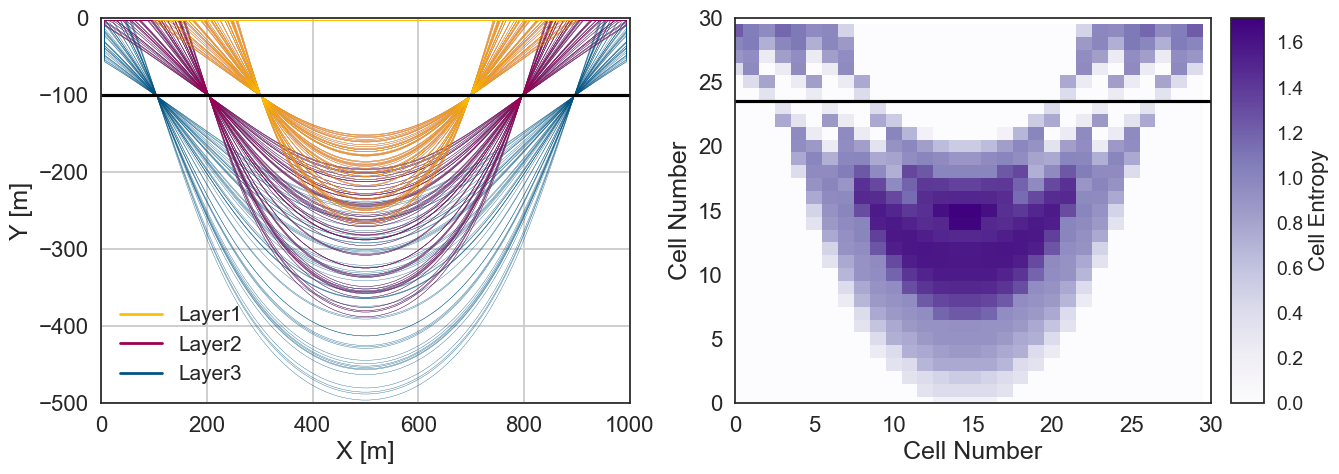

In [28]:
%matplotlib inline
fix, ax = plt.subplots(nrows=1, ncols=2,sharex=False, sharey=False, squeeze=True , figsize = (15,5))

custom_lines = [Line2D([0], [0], color='#ffbe00', lw=2),
                Line2D([0], [0], color='#9f0052', lw=2),
                Line2D([0], [0], color='#015482', lw=2)]


plot_pathdict(polygondict_s1, cdict, extent, ax=ax[0], surfaces=['Layer3'], color=cdict['Layer3'])
plot_pathdict(polygondict_s1, cdict, extent, ax=ax[0], surfaces=['Layer2'], color=cdict['Layer2'])
plot_pathdict(polygondict_s1, cdict, extent, ax=ax[0], surfaces=['Layer1'], color=cdict['Layer1'])

ax[0].set_aspect('auto')
ax[0].hlines(y=-100,xmin=0,xmax=1000, color='k')
ax[1].set_xlim(0,1000)  
ax[0].tick_params(axis='both', which='major', labelsize=16)
ax[0].tick_params(axis='both', which='minor', labelsize=16)
ax[0].set_xlabel('X [m]',fontsize=18)
ax[0].set_ylabel('Y [m]',fontsize=18)
ax[0].grid()
ax[0].legend(custom_lines, ['Layer1', 'Layer2', 'Layer3'], fontsize=15)


im = ax[1].imshow(np.fliplr(entropy_block_syncline_dip_all.reshape(30,30,30)[
               15].T), cmap='Purples', origin='lower', vmax = entropy_block_syncline_dip_all.max(),aspect="auto")
ax[1].set_xlabel('Cell Number',fontsize=18)
ax[1].set_ylabel('Cell Number',fontsize=18)
ax[1].hlines(y=23.5,xmin=0,xmax=200, color='k')
ax[1].set_xlim(0,30)
ax[1].set_ylim(0,30)

ax[1].tick_params(axis='both', which='major', labelsize=16)
ax[1].tick_params(axis='both', which='minor', labelsize=16)

divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size="7%", pad=0.2,)
cbar = fig.colorbar(im, cax=cax)

cbar.ax.tick_params(axis='both', which='major', labelsize=14)
cbar.ax.tick_params(axis='both', which='minor', labelsize=14)
cbar.ax.set_ylabel('Cell Entropy', fontsize=16)


fig.tight_layout()

plt.savefig('fig4.pdf', bbox_inches='tight', pad_inches=0.2)

### Plotting Meshes in 3D

In [29]:
meshes_layer2 = [mesh['Layer2'][0] for mesh in meshes]
meshes_layer2[0]

PolyData (0x1fd2d3a42e0)
  N Cells:	3362
  N Points:	1764
  N Strips:	0
  X Bounds:	1.667e+01, 9.833e+02
  Y Bounds:	1.103e+02, 8.897e+02
  Z Bounds:	-2.882e+02, -8.333e+00
  N Arrays:	1

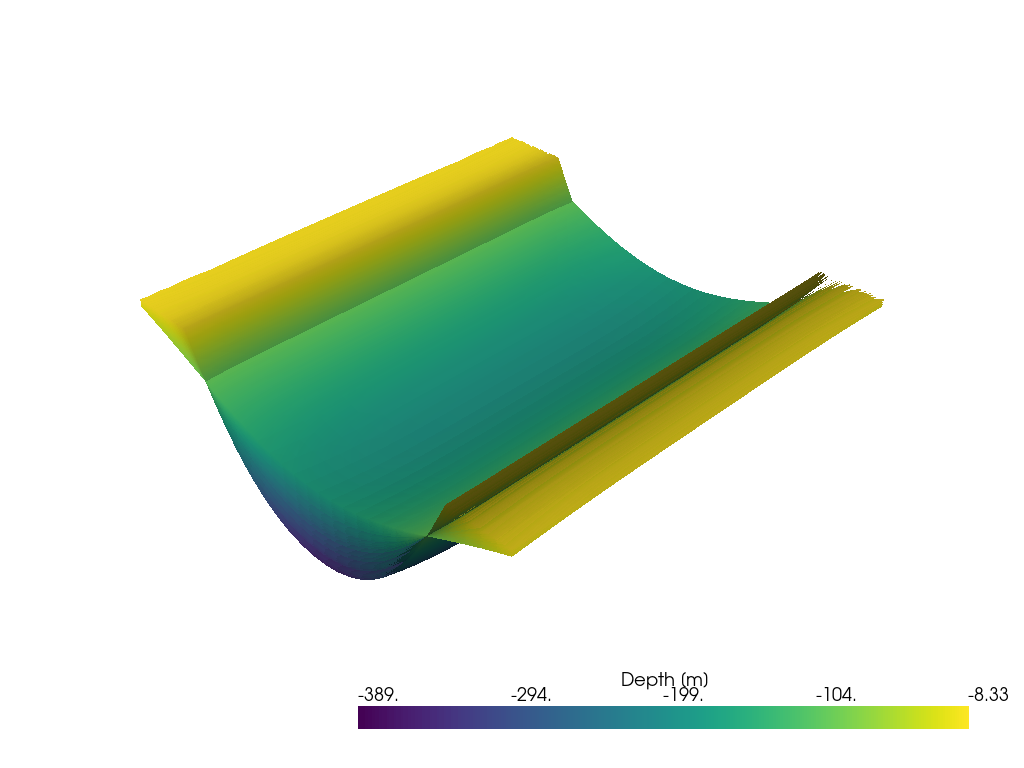

In [30]:
import pyvista as pv
p = pv.Plotter(notebook=True)

for mesh in meshes_layer2:
    p.add_mesh(mesh)
    
p.show()